<a href="https://colab.research.google.com/github/flatpickles/ML-Experiments/blob/main/Face_Replace.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Face Replace

This is an experimental image editing technique for generating new faces using Stable Diffusion. Faces are automatically detected (using MediaPipe's face detection model), and a mask indicating the face location is passed into a Stable Diffusion pipeline for inpainting.

In [1]:
# Import dependencies:

import cv2
import math
import numpy as np
import PIL
from base64 import b64decode, b64encode
from google.colab.output import eval_js
from google.colab.patches import cv2_imshow
from google.colab import files
from IPython.display import display, Javascript, Image


### Upload or capture an image

Your choice of an upload or a webcam capture – run either cell below. 

In [2]:
# Image upload:

uploaded = files.upload()
try:
  filename = list(uploaded.keys())[0]
  print('Opened {}'.format(filename))
  image_to_process = cv2.imread(filename)
except Exception as err:
  print(str(err))

Saving test_face.jpg to test_face.jpg
Opened test_face.jpg


In [ ]:
# Webcam capture:

def js_to_image(js_reply):
  image_bytes = b64decode(js_reply.split(',')[1])
  jpg_as_np = np.frombuffer(image_bytes, dtype=np.uint8)
  return cv2.imdecode(jpg_as_np, flags=1)

def take_photo(filename='photo.jpg', quality=1.0):
  js = Javascript('''
    async function takePhoto(quality) {
      const div = document.createElement('div');
      const capture = document.createElement('button');
      capture.textContent = 'Capture';
      div.appendChild(capture);

      const video = document.createElement('video');
      video.style.display = 'block';
      const stream = await navigator.mediaDevices.getUserMedia({video: true});

      document.body.appendChild(div);
      div.appendChild(video);
      video.srcObject = stream;
      await video.play();

      google.colab.output.setIframeHeight(document.documentElement.scrollHeight, true);

      await new Promise((resolve) => capture.onclick = resolve);

      const canvas = document.createElement('canvas');
      canvas.width = video.videoWidth;
      canvas.height = video.videoHeight;
      canvas.getContext('2d').drawImage(video, 0, 0);
      stream.getVideoTracks()[0].stop();
      div.remove();
      return canvas.toDataURL('image/jpeg', quality);
    }
    ''')

  display(js)
  data = eval_js('takePhoto({})'.format(quality))
  img = js_to_image(data)
  cv2.imwrite(filename, img)
  return filename

try:
  filename = take_photo()
  print('Saved to {}'.format(filename))
  image_to_process = cv2.imread(filename)
except Exception as err:
  print(str(err))

### Prepare and preview image

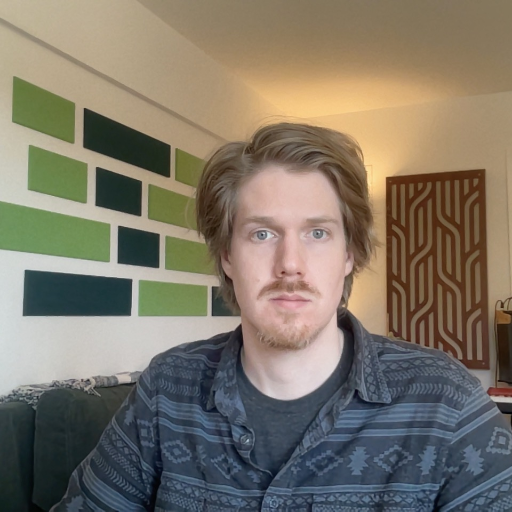

In [3]:
# Crop and scale input image(s) to work with Stable Diffusion:

IMAGE_SIZE = 512

def prepare_image(image, image_size):
  height, width, channels = image.shape
  scale = (image_size / width) if (width < height) else (image_size / height)
  resized_image = cv2.resize(image, (int(width * scale), int(height * scale)))
  x_inset = int((resized_image.shape[1] - image_size) / 2)
  y_inset = int((resized_image.shape[0] - image_size) / 2)
  cropped_image = resized_image[y_inset:(y_inset + image_size), x_inset:(x_inset + image_size)]
  return cropped_image

image_to_process = prepare_image(image_to_process, IMAGE_SIZE)
cv2_imshow(image_to_process)

### Create and preview face mask

In [ ]:
# Install mediapipe:

!pip install mediapipe

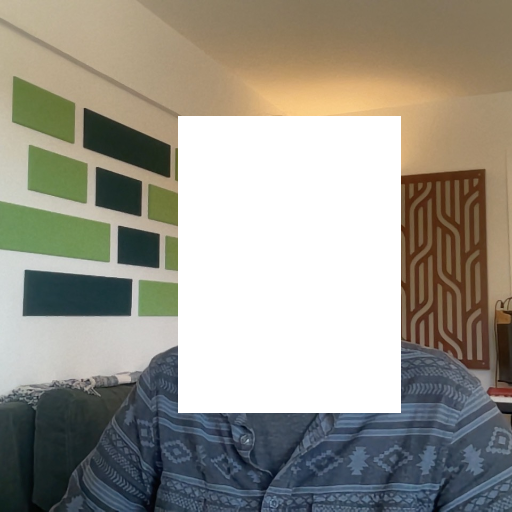

In [6]:
# Generate black & white mask image(s) for located face(s):

import mediapipe as mp
mp_face_detection = mp.solutions.face_detection

BOX_MULTIPLIER = (1.5, 2.0) # expand the bounding box around the face

def generate_mask(image, invert_mask = False):
  with mp_face_detection.FaceDetection(model_selection=1, min_detection_confidence=0.5) as face_detection:
    # Find face contained in image
    results = face_detection.process(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))

    # Generate an all black mask image
    height, width, channels = image.shape
    mask_image = image.copy()
    cv2.rectangle(
      mask_image,
      (0, 0),
      (width, height),
      (255, 255, 255) if invert_mask else (0, 0, 0),
      -1
    )

    # Add white to the mask where the face is detected
    if results.detections:
      box = results.detections[0].location_data.relative_bounding_box

      # Adjust box sizing - todo: could overflow bounds
      box.xmin -= (box.width * BOX_MULTIPLIER[0] - box.width) / 2
      box.width *= BOX_MULTIPLIER[0]
      box.ymin -= (box.height * BOX_MULTIPLIER[1] - box.height) / 2
      box.height *= BOX_MULTIPLIER[1]

      cv2.rectangle(
        mask_image,
        (math.floor(box.xmin * width), math.floor(box.ymin * height)),
        (math.floor((box.xmin + box.width) * width), math.floor((box.ymin + box.height) * height)),
        (0, 0, 0) if invert_mask else (255, 255, 255),
        -1
      )
    return mask_image

face_mask_image = generate_mask(image_to_process)
cv2_imshow(cv2.bitwise_or(image_to_process, face_mask_image))

### Set up Stable Diffusion

In [ ]:
# Install diffusers and other libraries:

!pip install diffusers transformers accelerate scipy safetensors xformers

In [ ]:
# Prepare for image generation:

from diffusers import StableDiffusionInpaintPipeline
import torch

device = "cuda"
pipe = StableDiffusionInpaintPipeline.from_pretrained(
    "stabilityai/stable-diffusion-2-inpainting",
    torch_dtype=torch.float16,
).to(device)

  0%|          | 0/50 [00:00<?, ?it/s]

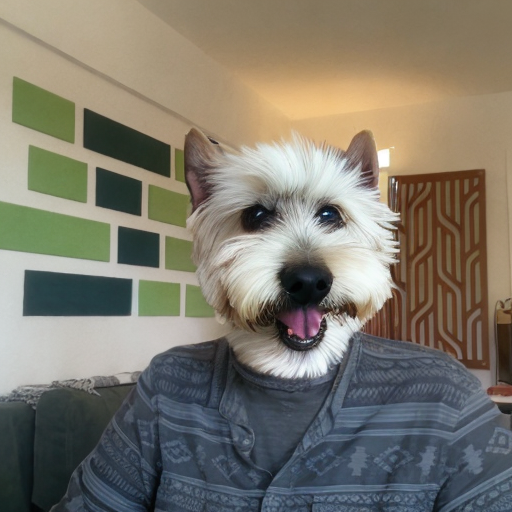

In [9]:
# Generate image!

prompt = "a dog head photo, high resolution"

guidance_scale=7.5
generator = torch.Generator(device=device).manual_seed(25)

pil_image = PIL.Image.fromarray(cv2.cvtColor(image_to_process, cv2.COLOR_BGR2RGB))
pil_mask = PIL.Image.fromarray(cv2.cvtColor(face_mask_image, cv2.COLOR_BGR2RGB))
image = pipe(
    prompt=prompt,
    image=pil_image,
    mask_image=pil_mask,
    guidance_scale=guidance_scale,
    generator=generator,
  ).images[0]
display(image)

### References:

- [Colab webcam notebook](https://colab.research.google.com/drive/1QnC7lV7oVFk5OZCm75fqbLAfD9qBy9bw?usp=sharing#scrollTo=XwUtEojjnPRb)
- [How to import files](https://medium.com/@rk.sarthak01/how-to-import-files-images-in-google-colab-from-your-local-system-46a801b1e568)
- [MediaPipe face detection](https://google.github.io/mediapipe/solutions/face_detection.html)
- [MediaPipe face mesh notebook](https://colab.research.google.com/github/kevinash/awesome-ai/blob/main/notebooks/5_FacesAndExpressions/MediaPipe_Face_Mesh.ipynb)
- [Convert PIL <-> cv2 images](https://stackoverflow.com/questions/43232813/convert-opencv-image-format-to-pil-image-format)
- [Stable Diffusion in-painting notebook](https://colab.research.google.com/github/huggingface/notebooks/blob/main/diffusers/in_painting_with_stable_diffusion_using_diffusers.ipynb)
- [Stable Diffusion 2 in-painting model](https://huggingface.co/stabilityai/stable-diffusion-2-inpainting)